In [2]:
import sys,os
import numpy as np
import pandas as pd
import datetime
import tqdm
import pickle
import h5py
from collections import deque
from math import ceil, sqrt, floor, gamma
from scipy import signal, stats, fftpack 
from sklearn import preprocessing
from PIL import Image
import multiprocessing as mp
import matplotlib.pyplot as plt
# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))

from sample import Sample
from dataset_simulation import DatasetSimulation

class CFARDetector(Sample):
    
    def __init__(self, dataset_location, site, file):
        super().__init__(dataset_location, site, file)
    
    #############
    """UTILITY"""
    
    def diff(self, signal, window):
        """Derivate the signal based on the dt=window
        Params
            signal: signal to be derivated
            window: time step
        Return
            first derivative of the signal"""
        windows = self.rolling(signal, window, 1)
        z = lambda w: (w[int(window/2):].mean()-w[:int(window/2)].mean())
        return np.array(list(map(z, windows)))
    
    def rolling(self, signal, window, stride, mode='full'):
        """Return a rolling window of the signal
        Params
            signal: signal to be rolled
            window: window size
            stride: stride used for sliding
            mode: 
                full: padded with zero such that the number of the windows is the 
                        same as the size of the signal
                valid: return non-padded windows
        Return
            roll: windows"""
        def _rolling(signal, window, stride):
            roll = []
            for ix in range(0,len(signal)-window+1,stride):
                roll.append(signal[ix:ix+window])
            return np.array(roll)
        roll = _rolling(signal, window, stride)
        if mode=='full':
            pad_size = len(signal)*stride+window-1 - len(signal)
            padded_signal = np.concatenate((np.full(ceil(pad_size/2), signal[0]), signal))
            padded_signal = np.concatenate((padded_signal, np.full(floor(pad_size/2), signal[-1])))
            roll = _rolling(padded_signal, window, stride)
        return np.array(roll)
    
    def get_corr(self, transforms, transforms_params, kernel):
        """Cross-Correlation result"""
        self.spectrogram_with_axis()
        self.apply_transform(transforms,transforms_params)
        return signal.correlate(10**self.get_spectrogram(), kernel, mode='valid')[0]
    
    def load_kernel(self, kernel_type, params):
        """Load whistler Kernel
        Params
            kernel_type: 
                mean - kernel extracted from training data
                sim - simulated whistler
        Return
            kernel: kernel data
        """
        if kernel_type=='mean':
            kernel_path = params[0]
            try:
                file = h5py.File(kernel_path, 'r+')
            except Exception as e:
                print('File: %s. Exception: %s'%(kernel_path,e))
            file_data = np.empty(file[kernel_path].shape,dtype=np.float64)
            file[kernel_path].read_direct(file_data)
            kernel = np.asarray(file_data)
            file.close()
        else:
            dataset_sim_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],
                                           os.environ.get('USER'), 
                                           'wdml', 'data','datasets', 'simulations', 'simple' ,'whistler')
            dataset_sim = DatasetSimulation(dataset_sim_loc)
            kernel = dataset_sim.whistler_sim(An=params[0], D0=params[1], magnitude=params[2])
        return kernel
    
    ###################
    """CFAR DETECTOR"""
    
    def ca_cfar(self, transforms, transforms_params, kernel, cfar_params):
        """Cell Averaging Constant False Alarm Rate (CFAR)
        Params
            ...
            cfar_params: [N,G,pfa]
                            N: number of noise cells on each side of the CUT 
                            G: number of gaurd cells on each side of the CUT
                            pfa: probability of false alarm
        Return
            detector: adaptive threshold
        """
        self.spectrogram_with_axis()
        self.apply_transform(transforms,transforms_params)
        corr = signal.correlate(10**self.get_spectrogram(), kernel, mode='valid')[0]
        N,G,pfa = cfar_params
        # apply CFAR
        stride=1
        ca = 2*N*((pfa**(-1/(2*N)))-1)
        threshold = lambda w: ca*(((w[:N]**2).sum()+(w[N+2*G+1:]**2).sum())/(2*N))
        windows = self.rolling(corr, window=2*(N+G)+1, stride=stride)
        detector = np.array(list(map(threshold, windows)))
        return detector
    
    def os_cfar(self, transforms, transforms_params, kernel, cfar_params):
        """Order Statistic Constant False Alarm Rate (OS CFAR)
        Params
            ...
            cfar_params: [N,G,k,pfa]
                            N: number of noise cells on each side of the CUT 
                            G: number of gaurd cells on each side of the CUT
                            k: kth order statistic, 2N-k >= nbr of expected cell targets
                            pfa: probability of false alarm
        Return
            detector: adaptive threshold"""
        self.spectrogram_with_axis()
        self.apply_transform(transforms,transforms_params)
        corr = signal.correlate(10**self.get_spectrogram(), kernel, mode='valid')[0]
        N,G,k,pfa = cfar_params
        # apply CFAR
        stride = 1
        ca = 2*N*((pfa**(-1/(2*N)))-1)
        threshold = lambda w: ca*((np.sort(np.concatenate((w[:N],w[N+2*G+1:])))[k])**2)
        windows = self.rolling(corr, window=2*(N+G)+1, stride=stride)
        detector = np.array(list(map(threshold, windows)))
        return detector
    
        
    def tm_cfar(self, transforms, transforms_params, kernel, cfar_params):
        """Trimmed Mean Constant False Alarm Rate (TM CFAR)
        Params
            ...
            cfar_params: [N,G,k,pfa]
                            N: number of noise cells on each side of the CUT 
                            G: number of gaurd cells on each side of the CUT
                            T1: number of smallest cells to discard
                            T2: number of highest cells to discard
                            pfa: probability of false alarm
        Return
            detector: adaptive threshold"""
        self.spectrogram_with_axis()
        self.apply_transform(transforms,transforms_params)
        corr = signal.correlate(10**self.get_spectrogram(), kernel, mode='valid')[0]
        N,G,T1,T2,pfa = cfar_params
        # apply CFAR
        stride = 1
        ca = 2*N*((pfa**(-1/(2*N)))-1)
        threshold = lambda w: ca*((np.sort(np.concatenate((w[:N],w[N+2*G+1:])))[T1:2*N-T2])**2).sum()/(2*N-(T2+T1))
        windows = self.rolling(corr, window=2*(N+G)+1, stride=stride)
        detector = np.array(list(map(threshold, windows)))
        return detector
    
    def fusion_cfar(self, transforms, transforms_params, kernel, cfar_params):
        """Apply the fusion CFAR algorithm on the pulses obtainde from the cfar techniques
        Params
            ...
            cfar_params: [N,G,k,pfa]
                            N: number of noise cells on each side of the CUT 
                            G: number of gaurd cells on each side of the CUT
                            k: kth order statistic, 2N-k >= nbr of expected cell targets
                            T1: number of smallest cells to discard
                            T2: number of highest cells to discard
                            pfa: probability of false alarm
        Return
            detector: adaptive threshold"""
        N,G,k,T1,T2,pfa = cfar_params
        ca = self.detection_pulse(transforms, transforms_params, kernel, 'ca_cfar', [N,G,pfa])
        os = self.detection_pulse(transforms, transforms_params, kernel,  'os_cfar', [N,G,k,pfa])
        tm = self.detection_pulse(transforms, transforms_params, kernel, 'tm_cfar', [N,G,T1,T2,pfa])
        fusion = np.bitwise_or(np.bitwise_and(ca,np.bitwise_or(os,tm)), np.bitwise_and(os,tm))
        return fusion
        
    def apply_cfar_detector(self, transforms, transforms_params, kernel, cfar, cfar_params):
        """Apply a CFAR detector
        Params
            ...
            cfar: type of cfar techniques
            cafar_params: parameters of the cfar techniques
        Return
            detector: adaptive threshold"""
        if cfar=='ca_cfar':
            return self.ca_cfar(transforms, transforms_params, kernel, cfar_params)
        if cfar=='os_cfar':
            return self.os_cfar(transforms, transforms_params, kernel, cfar_params)
        if cfar=='tm_cfar':
            return self.tm_cfar(transforms, transforms_params, kernel, cfar_params)
    
    ######################
    """DETECTOR RESULTS"""
    
    def detection_pulse(self, transforms, transforms_params, kernel, cfar, cfar_params):
        """Detection decision pulse
        Params
            ...
            cfar: type of cfar techniques
            cafar_params: parameters of the cfar techniques
        Return
            pulses: cfar detector decisions"""
        self.spectrogram_with_axis()
        self.apply_transform(transforms,transforms_params)
        corr = signal.correlate(10**self.get_spectrogram(), kernel, mode='valid')[0]
        corr_sqrt = corr**2
        get_pulse = lambda detector: np.array([True if sig>thres else False for sig,thres in zip(corr_sqrt,detector)])
        if cfar=='ca_cfar':
            pulses = get_pulse(self.ca_cfar(transforms, transforms_params, kernel, cfar_params))
        if cfar=='os_cfar':
            pulses = get_pulse(self.os_cfar(transforms, transforms_params, kernel, cfar_params))
        if cfar=='tm_cfar':
            pulses = get_pulse(self.tm_cfar(transforms, transforms_params, kernel, cfar_params))
        if cfar=='fusion_cfar':
            pulses = self.fusion_cfar(transforms, transforms_params, kernel, cfar_params)
        pulses[0], pulses[-1] = False, False
        return pulses

    def detection_starting_locations(self, transforms, transforms_params, kernel, cfar, cfar_params):
        """Location of the whistler after detection
        Params
            ...
            cfar: type of cfar techniques
            cafar_params: parameters of the cfar techniques
        Return
            indices: indices of detected whistler, indices as starting point and not 5kHz point
        """
        corr = self.get_corr(transforms, transforms_params, kernel)
        pulses = self.detection_pulse(transforms, transforms_params, kernel, cfar, cfar_params)
        spikes = self.diff(pulses,2)
        highs,lows = np.argwhere(spikes==1), np.argwhere(spikes==-1)
        assert len(highs)==len(lows)
        ix = []
        for h,l in zip(highs, lows):
            h,l = h[0], l[0]
            i = h+np.argmax(corr[h:l])
            r = 10*np.log10(corr[i]**2)
            ix.append(['%.3f'%(i*self.get_time_res()),'%.3f'%r])
        ix = np.array(ix)
        return ix
    
    def detection_starting_locations_final(self, transforms, transforms_params, kernel, cfar, cfar_params, threshold=0, time_error=1):
        """Location of the whistler after detection
        Params
            ...
            cfar: type of cfar techniques
            cafar_params: parameters of the cfar techniques
            threshold:
            time_error: number of decimal places for time onversion
        Return
            final: starting time and matching correlatiob
        """
        starts = self.detection_starting_locations(transforms, transforms_params, kernel, cfar, cfar_params)
        if len(starts)==0: return np.array([])
        thresholded = []
        # round as per time_err decimal point
        for s in starts:
            if float(s[1])>=threshold:
                thresholded.append([round(float(s[0]),time_error), float(s[1])])
        thresholded = np.array(thresholded)
        uniques = np.sort(np.array(list(set(thresholded[:,0]))))
        # get maximum corr per time_error point
        final = np.array([[u, thresholded[np.argwhere(thresholded[:,0]==u).ravel(),1].max()] for u in uniques])
        return final
    
    def detection_bounding_boxes(self, transforms, transforms_params, kernel, cfar, cfar_params, threshold=0, time_error=1, duration=False):
        """Location of the whistler after detection
        Params
            ...
            cfar: type of cfar techniques
            cafar_params: parameters of the cfar techniques
            threshold:
            time_error: number of decimal places for time onversion
        Return
            bbox: bounding box [x1,x2,y1,y2,c] in time and frequency with c, the result of the correlation
        """
        output = self.detection_starting_locations_final(transforms, transforms_params, kernel, 
                                                        cfar, cfar_params, threshold=threshold, time_error=time_error)
        self.spectrogram_with_axis()
        self.apply_transform(transforms,transforms_params)
        bboxes = []
        if duration:
            for o in output:
                start = o[0]
                bbox = np.array([int(start/self.get_time_res()),int((start+1)/self.get_time_res()),int(1.5/self.get_freq_res()),int(9.5/self.get_freq_res())])
                data = self.get_spectrogram()[bbox[2]:bbox[3],bbox[0]:bbox[1]]
                D0 = np.linspace(20,80,61)
                peaks = []
                dataset_sim_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'simulations', 'simple' ,'whistler')
                dataset_sim = DatasetSimulation(dataset_sim_loc, self.get_time_res(), self.get_freq_res())
                for d in D0:
                    kernel = dataset_sim.whistler_sim(An=0.35, D0=d, magnitude=1)
    #                 print(data.shape, kernel.shape)
                    corr = signal.correlate(data, kernel[:data.shape[0],:], mode='valid')[0]
                    peaks.append(corr.max())
                duration = dataset_sim.whistler_sim(An=0.35, D0=D0[np.argmax(peaks)], magnitude=1).shape[1]*self.get_time_res()
                bboxes.append([ o[1],round(start,time_error),round(start+duration,time_error),1.5,9.5])
        else:
            bboxes = [[ o[1],o[0], o[0]+1, 1.5, 9.5] for o in output]
        return np.array(bboxes)
    
    ###########
    """PLOTS"""
    
    def plot_corr_output(self, transforms, transforms_params, cfar, cfar_params, kernel, 
                         vlines = [], thresholds=[], detection=False, mean=False, figsize=None, title=None,
                         font=[None]*5, squared=True, legend_loc=None):
        """Plot result of correlation with thresholds
        Param
            ...
            vlines: vertical lines to plot
            threshold: horizontal lines
            detection: True for cfar threshold
            squared: True for corr**2"""
        plt.figure() if not figsize else plt.figure(figsize=figsize)
        legend = []
        for t, t_params in zip(transforms, transforms_params):
            self.spectrogram_with_axis()
            self.apply_transform(t, t_params)
            corr = signal.correlate(10**self.get_spectrogram(), kernel, mode='valid')[0]
            corr = corr**2 if squared or detection else corr
            corr = 10*np.log10(corr)
            corr = corr-corr.mean() if mean else corr
            plt.plot(list(range(len(corr))*self.get_time_res()),corr, linewidth=font[-1])
            legend.append(t)
            if detection:
                for c, c_params in zip(cfar,cfar_params):
                    detector = self.apply_cfar_detector(t, t_params, kernel, c, c_params)
                    plt.plot(list(range(len(corr))*self.get_time_res()),10*np.log10(detector), linewidth=font[-1])
                    legend.append(c)
        for threshold in thresholds:
            plt.plot(list(range(len(corr))*self.get_time_res()), np.full(len(corr), threshold), linewidth=font[-1])
            legend.append('T = %.2f dB'%threshold)
        for line in vlines:
            plt.axvline(line,color='black', linewidth=font[-1])
        plt.xticks(np.linspace(0,len(corr),20)*self.get_time_res())
        plt.autoscale(tight=True)
        plt.title(title,fontsize=font[0])
        plt.legend(legend,fontsize=font[1], loc=legend_loc)
        plt.xlabel('Time [s]',fontsize=font[2])
        plt.ylabel('[dB]',fontsize=font[2])
        plt.xticks(fontsize=font[3])
        plt.yticks(fontsize=font[3])
        plt.show()
    
    def plot_detection_pulse(self, transforms, transforms_params, cfar, cfar_params, kernel, 
                            figsize=None, title='Detection Area',font=[None]*5):
        """pulse where signal square is above the threshold"""
        self.spectrogram_with_axis()
        self.apply_transform(transforms,transforms_params)
        corr = signal.correlate(10**self.get_spectrogram(), kernel, mode='valid')[0]        
        loc_area = self.detection_pulse(transforms, transforms_params, kernel, cfar, cfar_params)
        plt.figure() if not figsize else plt.figure(figsize=figsize)
        plt.plot(list(range(len(loc_area))*self.get_time_res()),loc_area, linewidth=font[-1])
        plt.xticks(np.linspace(0,len(corr),20)*self.get_time_res())
        plt.autoscale(tight=True)
        plt.title(title,fontsize=font[0])
        plt.xlabel('Time [s]',fontsize=font[2])
        plt.ylabel('Decisions',fontsize=font[2])
        plt.xticks(fontsize=font[3])
        plt.yticks(fontsize=font[3])
        plt.show() 
        
    ##########################
    """DETECTION EVALUATION"""
    
    def output_compare(self, output, diff_err, time_err):
        """Compare the proximity of the output using this detector to the awd output"""
        output_awd = self.awda_whistlers(time_err=time_err)
        output_mf = self.awda_whistlers(time_err=time_err,_output=output)
        output_mf = np.array([]) if len(output_mf)==0 else output_mf[0]
        output_awd = output_awd[0]
        output_awd,output_mf=list(output_awd),list(output_mf)
        queue = []
        within_range = lambda out1,out2,err: True if abs(out1-out2)<=err else False
        last_entry = output_awd[-1] 
        end = False
        while(not end):
            for awd, awd_ix in zip(output_awd, range(len(output_awd))):
                for mf, mf_ix in zip(output_mf, range(len(output_mf))):
                    if within_range(awd[0],mf[0],diff_err):
                        queue.append(np.array([awd,0]))
                        del output_awd[awd_ix]
                        del output_mf[mf_ix]
                        break
                else:
                    continue
                break
            if last_entry[0]==awd[0]:
                end=True
        for awd in output_awd:
            queue.append(np.array([awd,-1]))
        for mf in output_mf:
            queue.append(np.array([mf, 1]))
        return np.array(queue)
    
    def metric(self, output, diff_err, time_err):
        """Give metric of detection"""
        queue = self.output_compare(output,diff_err, time_err)
        count = np.zeros(3, dtype=np.int)
        for q in queue[:,1]:
            if q==-1:
                count[0]+=1
            elif q==0:
                count[1]+=1
            elif q==1:
                count[2]+=1
        return count
    
        
    def evaluate_detector(self, transforms, transforms_params, detector, detector_params, diff_err, time_err, kernel,segmented=False):
        if segmented:
            corr = self.segmented_correlation(transforms, transforms_params, kernel,mode='valid')[1]
        else:
            self.spectrogram_with_axis()
            self.apply_transform(transforms,transforms_params)
            corr = signal.correlate(10**self.get_spectrogram(), kernel, mode='valid').T
        detector = self.apply_detector(corr,detector, detector_params)
        shift = detector_params[0]+detector_params[1]+int(kernel.shape[1]/3)
        output = self.detection_loc(corr, detector, shift)
        return np.array([self.get_file(),self.output_compare(output, diff_err=diff_err,time_err=time_err), self.metric(output, diff_err=diff_err,time_err=time_err)])
    
    def evaluate_detector_ml(self, transforms, transforms_params, input_shape, scaler, model, diff_err, time_err):
        self.spectrogram_with_axis()
        self.apply_transform(transforms,transforms_params)
        detection, prob, shift = self.detection_area_ml(input_shape, scaler, model) ####
        output = self.detection_loc_ml(detection, prob,shift)
        return np.array([self.get_file(),self.output_compare(output, diff_err=diff_err,time_err=time_err), self.metric(output, diff_err=diff_err,time_err=time_err)])
    
    def evaluate_detector_ml_cnn_ouput(self, prob, shift ,diff_err, time_err, window=10,threshold=0.6, e=-0.05):
        detection = self.prob_area_ml(prob[:,1],window=window,threshold=threshold,e=e)
        output = self.detection_loc_ml(detection, prob,shift)
        return np.array([self.get_file(),self.output_compare(output, diff_err=diff_err,time_err=time_err), self.metric(output, diff_err=diff_err,time_err=time_err)])

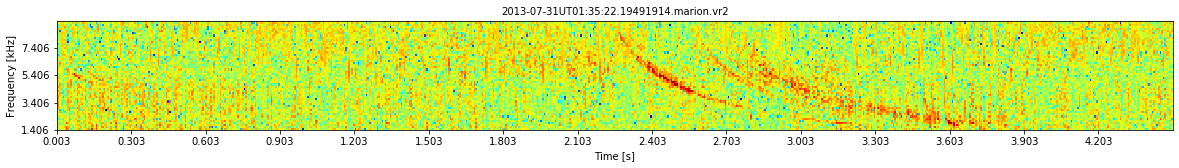

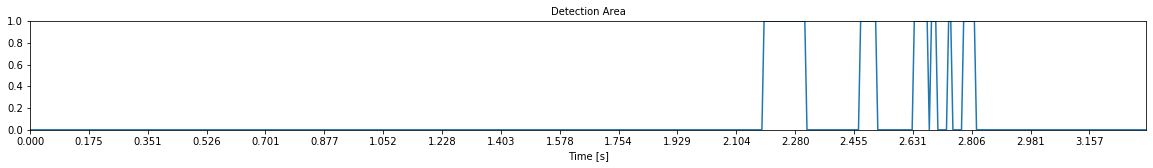

[['2.213' '98.861']
 ['2.513' '76.475']
 ['2.667' '83.952']
 ['2.692' '88.934']
 ['2.744' '89.029']
 ['2.782' '84.526']]
[[2.2 2.9 1.5 9.5]
 [2.5 3.2 1.5 9.5]
 [2.8 3.4 1.5 9.5]
 [2.7 3.4 1.5 9.5]]


In [56]:
# from sample import Sample
# from dataset import Dataset
# from database import Database
# dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
# database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
# site = 'marion'
# my_dataset = Dataset(dataset_loc, site)
# my_database = Database(dataset_loc, database_loc, site)

# transforms, transforms_params = ['slice','zscore'],[[1.5,9.5],[None]]
# N, G = 10 , 7
# X_dB = 8
# pfa = (1/(1+(10**(X_dB/10))/(2*N)))**(2*N)
# k = N-1
# TS,TL = floor(N/3), N
# cfar, cfar_params = 'fusion_cfar', [N,G,k,TS,TL,pfa]
# # reason for adaptive threshold

# file = '2013-07-31UT01:35:22.19491914.marion.vr2'

# sample = CFARDetector(dataset_loc, site, file)
# sample.spectrogram_with_axis(log10=True)
# freq_size=4
# sample.set_figsize(freq_size*sample.get_time_freq_ratio(dec=0), freq_size/2)
# figsize=sample.get_figsize()
# sample.apply_transform(transforms, transforms_params)
# sample.spectrogram_plot(figsize=sample.get_figsize(), xlabel='Time [s]', ylabel='Frequency [kHz]',zlabel='sprectrum magnitude [dB]', 
#                            xaxis=True, yaxis=True,ticks=[0.3,2],title=sample.get_file(), cmap='jet', cmap_show=False)
# kernel = sample.load_kernel('sim', [0.35,80,1])

# sample.plot_detection_pulse(transforms,transforms_params, cfar, cfar_params, kernel, figsize=figsize)
# starts = sample.detection_starting_locations(transforms,transforms_params, kernel, cfar, cfar_params)
# print(starts)
# bboxes = sample.detection_bounding_boxes(transforms, transforms_params, kernel, cfar, cfar_params, threshold=0, time_error=1)
# print(bboxes)

In [ ]:
    
    ###########################
    # ML
#     def detection_area_ml(self, input_shape, scaler, model):
#         """Return a pulse representing the detection location"""
#         detection, prob = [], []
#         freq_len,time_len = input_shape
#         to_evt = lambda x: 1 if x==1 else 0
#         my_spec = self.get_spectrogram()
#         for ix in range(my_spec.shape[1]-time_len+1):
#             spec = my_spec[:,ix:ix+time_len]
#             spec = spec.reshape(1,freq_len*time_len)
#             spec = scaler.transform(spec)
#             spec = spec.reshape(1,1,freq_len,time_len)
#             detection.append(to_evt(np.argmax(model.predict(spec)[0])))
#             prob.append(model.predict(spec)[0])
#         detection = np.array(detection)
#         prob = np.array(prob)
#         shift = int(time_len/3)
#         return detection, prob, shift
    
#     def detection_loc_ml(self, detection, prob, shift):
#         """"Transform the detection pulse in detection locations"""
#         detection[0], detection[-1] = False, False
#         loc = np.array([x if x>0 else x for x in self.diff(detection, 2)])
#         high,low = np.argwhere(loc==1), np.argwhere(loc==-1)
#         assert len(high)==len(low)
#         ix = []
#         for h,l in zip(high, low):
#             i = int((h[0]+l[0])/2)+shift
#             i = i if i<len(detection) else len(detection)-1
#             ix.append([str(i*self.get_time_res()),str(prob[i-shift,1])])
#         ix = np.array(ix)
#         return ix
    
#     def prob_area_ml(self, cnn_output, window = 10, threshold = 0.6, e=-0.05):
#         """Return location are of detection based on second derivatives"""
#         output = np.array([x if x>threshold else threshold for x in cnn_output])
#         # find the second derivative
#         output = self.diff(output, window)
#         output = self.diff(output, window)
#         # get the negative value of the output
#         output = np.array([1 if x<e else 0 for x in output])
#         return output
    
#     def prob_output_ml(self, transforms, transforms_params, input_shape, scaler, model):
#         """Return the cnn probabilities of the spectrogram"""
#         self.spectrogram_with_axis()
#         self.apply_transform(transforms,transforms_params)
#         detection, prob, shift = self.detection_area_ml(input_shape, scaler, model)
#         return self.get_file(), prob, shift
    
    
#     def plot_prob_output_ml(self, transforms,transforms_params,input_shape, scaler, model):
#         self.spectrogram_with_axis()
#         self.apply_transform(transforms,transforms_params)
#         detection, prob, shift = self.detection_area_ml(input_shape, scaler, model)
#         plt.figure(figsize=size)
#         plt.plot(list(range(shift,len(prob[:,1])+shift)*self.get_time_res()),prob[:,1])
#         plt.plot(list(range(shift,len(prob[:,1])+shift)*self.get_time_res()),np.full_like(prob[:,1],0.5))
#         plt.xticks(np.linspace(shift,len(detection)+shift,20)*self.get_time_res())
#         plt.legend(['Detection Probabilities', 'Threshold'])
#         plt.title('Whistler Detection Probabilties')
#         plt.show()
        
#     def plot_detection_area_ml(self, transforms,transforms_params,input_shape, scaler, model):
#         self.spectrogram_with_axis()
#         self.apply_transform(transforms,transforms_params)
#         detection, prob, shift = self.detection_area_ml(input_shape, scaler, model)
#         plt.figure(figsize=size)
#         plt.plot(list(range(shift,len(detection)+shift)*self.get_time_res()),detection)
#         plt.xticks(np.linspace(shift,len(detection)+shift,20)*self.get_time_res())
#         plt.title('Detection Area')
#         plt.show()

    ########################################

2013-07-11UT05:39:45.20931938.marion.vr2


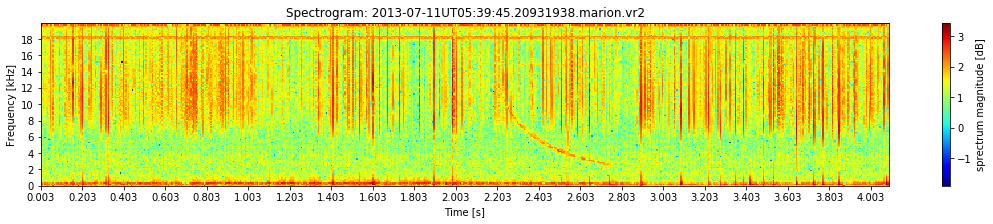

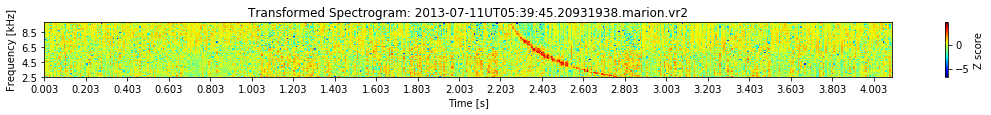

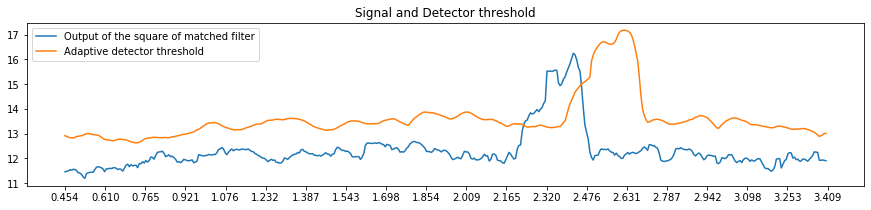

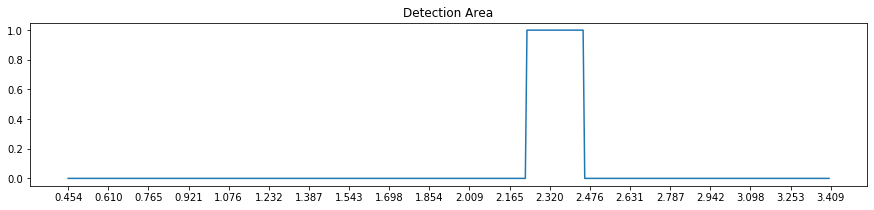

['2013-07-11UT05:39:45.20931938.marion.vr2'
 array([[array([  2.42868, 313.     ]), 0]], dtype=object)
 array([0, 1, 0])]


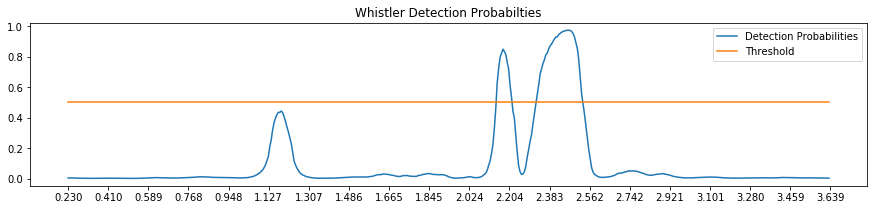

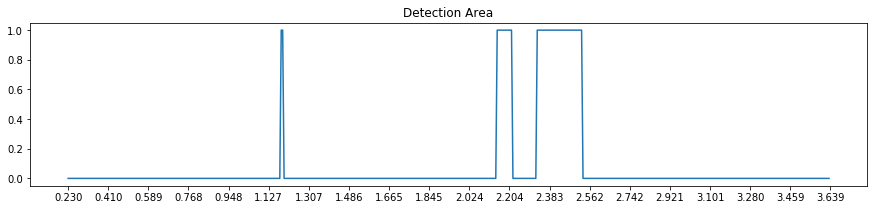

['2013-07-11UT05:39:45.20931938.marion.vr2'
 array([[array([  2.42868, 313.     ]), 0],
       [array([1.183075  , 0.44316116]), 1],
       [array([2.1743    , 0.84951955]), 1]], dtype=object)
 array([0, 1, 2])]


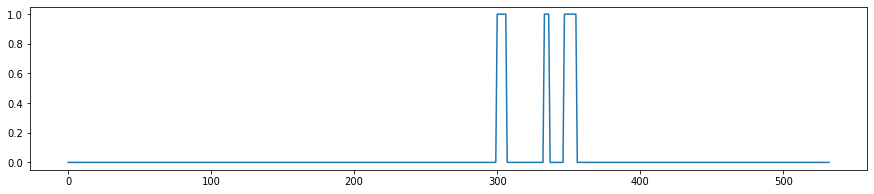

array(['2013-07-11UT05:39:45.20931938.marion.vr2',
       array([[array([  2.42868, 313.     ]), 0],
       [array([2.16151  , 0.7946705]), 1],
       [array([2.46847   , 0.97439414]), 1]], dtype=object),
       array([0, 1, 2])], dtype=object)

In [2]:
# from sample import Sample
# from dataset import Dataset
# from database import Database
# dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
# database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
# site = 'marion'
# my_dataset = Dataset(dataset_loc, site)
# my_database = Database(dataset_loc, database_loc, site)
# file = np.random.choice(my_database.get_test(),1)[0]
# # 
# # file = '2013-07-25UT04:30:47.73731922.marion.vr2' #1
# # file= '2013-06-25UT14:04:42.60451922.marion.vr2' #2 # USE THIS FOR POSTER
# # file = '2013-01-27UT00:58:07.81987602.marion.vr2'   # use this in research
# # file = '2013-07-02UT14:23:00.07651914.marion.vr2'
# # file = '2013-07-02UT15:03:58.44451914.marion.vr2'
# # file = '2013-07-07UT14:34:37.06211914.marion.vr2'
# # file = '2013-06-09UT12:52:37.22969609.marion.vr2' #4 # use THIS instead
# # file = '2013-05-18UT13:22:09.68232156.marion.vr2'
# # file = '2013-05-20UT16:18:21.03742156.marion.vr2'  # ML detects more
# # file = '2013-05-20UT16:18:21.03742156.marion.vr2'
# # file = '2013-05-18UT13:49:22.14312156.marion.vr2'
# my_sample = SampleDetector(dataset_loc, site,file)

# my_sample.spectrogram_with_axis(log10=True)
# print(my_sample.get_file())
# time_err=0.1
# diff_err=0.1
# freq_size = 3
# freq_slice = [2.5,10]
# detector, detector_params = 'tm_cfar', [10,25,1e-6,10]
# transforms, transforms_params = ['slice','zscore'],[freq_slice,[None]]
# size = (freq_size*my_sample.get_time_freq_ratio(dec=0), freq_size)

# # time and time-frequency
# # my_sample.signal_plot(sig=None, EW=True, figsize=size, title="ADC signal: "+my_sample.get_file())
# my_sample.spectrogram_plot(figsize=(size[0]+4,size[1]), xlabel='Time [s]', ylabel='Frequency [kHz]',zlabel='sprectrum magnitude [dB]', 
#                            xaxis=True, yaxis=True, ticks=[0.2,2],
#                            title="Spectrogram: "+my_sample.get_file(), cmap='jet', cmap_show=True)
# # transformation
# # r1, l1 = my_sample.spectrogram_time_cut_plot([2.5,2], figsize=size, title='Whstler and Spheric levels before pre-processing', 
# #                                     legend=['Whistler', 'Spheric'], stats=True, legend_loc='upper right')
# # my_sample.apply_transform(['zscore'], [[None]])
# # r2, l2 = my_sample.spectrogram_time_cut_plot([2.5,2], figsize=size, title='Whstler and Spheric levels after pre-processing', 
# #                                     legend=['Whistler', 'Spheric'], stats=True, legend_loc='upper right')

# # my_sample.spectrogram_with_axis()
# # my_sample.apply_transform(['slice'], [[2.5,10]])
# # my_sample.spectrogram_plot(figsize=(size[0]+4,size[1]-2), xlabel='Time [s]', ylabel='Frequency [kHz]',zlabel='spectrum magnitude dB', 
# #                            xaxis=True, yaxis=True, ticks=[0.2,2],
# #                            title="Transformed Spectrogram: "+my_sample.get_file(), cmap='jet', cmap_show=True)
# my_sample.spectrogram_with_axis()
# my_sample.apply_transform(transforms, transforms_params)
# my_sample.spectrogram_plot(figsize=(size[0]+4,size[1]-2), xlabel='Time [s]', ylabel='Frequency [kHz]',zlabel='Z score', 
#                            xaxis=True, yaxis=True, ticks=[0.2,2],
#                            title="Transformed Spectrogram: "+my_sample.get_file(), cmap='jet', cmap_show=True)


# # matched filter
# my_sample.spectrogram_with_axis()
# kernel = my_sample.whistler_sim(decay=3, whistler_time=0.7, whistler_freq_len=7.5, whistler_freq_start=2.5, 
#                                 thickness=1,size=50,freq_slice=freq_slice)
# # fig=plt.figure(figsize=(3,1));
# # img=plt.pcolormesh(np.linspace(0,0.7,kernel.shape[1]),np.linspace(2.5,10,kernel.shape[0]),kernel, cmap='jet');
# # fig.colorbar(mappable=img, label='Kernel')
# # plt.title("Whistler Simulation");plt.xlabel('Time [s]');plt.xlabel('Frequency [kHz]');plt.show();
# my_sample.plot_corr_output(transforms, transforms_params, detector, detector_params, diff_err, time_err, kernel)
# my_sample.plot_detection_area(transforms, transforms_params, detector, detector_params, diff_err, time_err, kernel)
# evaluation = my_sample.evaluate_detector(transforms, transforms_params,detector, detector_params, diff_err=diff_err, time_err=time_err, kernel=kernel)
# print(evaluation)

# # machine learning
# aug=True
# transforms, transforms_params = ['zscore'],[[None]]
# params = str(transforms)+'_'+str(transforms_params)
# params +='_aug' if aug else ''
# scaler_path = os.path.join(database_loc,site,'models',params+'_scaler.pickle')
# model_path = os.path.join(database_loc,site,'models',params+'_model.h5')
# input_shape = [48,108]

# scaler = pickle.load( open( scaler_path, "rb" ) )['scaler']
# model = load_model(model_path)

# transforms, transforms_params = ['slice','zscore'],[[2.5,10],[None]]
# my_sample.plot_prob_output_ml(transforms, transforms_params ,input_shape, scaler, model)                   
# my_sample.plot_detection_area_ml(transforms, transforms_params ,input_shape, scaler, model)
# evaluation = my_sample.evaluate_detector_ml(transforms, transforms_params ,input_shape, scaler, model, diff_err, time_err)
# print(evaluation)

# f,prob,shift = my_sample.prob_output_ml(transforms, transforms_params, input_shape, scaler, model)
# plt.figure(figsize=size)
# plt.plot(my_sample.prob_area_ml(prob[:,1], window = 10, threshold = 0.6, e=-0.05))
# plt.show()
# my_sample.evaluate_detector_ml_cnn_ouput(prob=prob, shift=shift ,diff_err=diff_err, time_err=time_err, window=10,threshold=0.6, e=-0.05)